# Zurich open data exploration

## Reading csv, json and shape format datasets. Combining them into one central file, and visualizing some elements.

One of the goals of our project is to study urban environment of Zurich city and afterwards associate it with insurance data. For this purpose, we will be utilizing public datasets published on <a href="url">https://data.stadt-zuerich.ch/</a> website. Datasets we will be using contain, but are not limited to, public parks, schools, street lights, public WCs and etc. in Zurich. 

This notebook is used to load all relevant datasets found on https://data.stadt-zuerich.ch/ as well as the population per zip code data from https://opendata.swiss/en/dataset/bevoelkerung-pro-plz into a central file that will be used for the rest of the analysis.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from os import listdir
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pyproj

In [3]:
DATA_FOLDER = "./data/"
CSV_JSON_FOLDER = DATA_FOLDER + './csv_json_files/'
SHAPE_FOLDER = DATA_FOLDER + "shapeFiles/"

## Reading and loading the csv files

In [4]:
# create function that reads cleans and appends csv to the general dataframe
def csv_read_clean_append(csv_file, duplicate_check, group_on, new_column, append_target=None):
    
    # load csv into dataframe, drop any duplacte rows, count values for group_on series 
    temp_df = pd.read_csv(CSV_JSON_FOLDER + csv_file).drop_duplicates(duplicate_check)[group_on].value_counts().to_frame(new_column)
    
    if append_target is None:
        return temp_df
    else:
        return append_target.join(temp_df)

In [5]:
# start with addresses and number of hospitality companies
combined_df = csv_read_clean_append('adressen.csv', 'adresse', 'plz', 'addresses')
combined_df = csv_read_clean_append('gastwirtschaftsbetriebe_per_20171231.csv',\
                                    'Betriebsname', 'plz', 'hospitality_companies', combined_df)

We now insert the population per zip code. We have to do some manual touching up, as the population is a sum of number of women and men.

In [6]:
# read population per zip code file
population_df = pd.read_csv(CSV_JSON_FOLDER +'bevoelkerung_proplz.csv',delimiter=';')

# sum the men and women count per zip code to get population per zip code
population_df = population_df[population_df['typ']\
                                .isin(['w', 'm'])]\
                                .groupby('plz')['anzahl']\
                                .agg('sum')\
                                .to_frame('population')

# merge the population data to the rest
combined_df = pd.merge(combined_df, population_df, 'inner', left_index=True, right_index=True)
combined_df.head()

,addresses,hospitality_companies,population
8050,4134,153.0,34412
8049,3498,34.0,27853
8048,3492,95.0,33499
8032,3403,50.0,23866
8046,3016,31.0,29139


## Reading and loading the json files

In [7]:
# create function that reads cleans and appends json datasets to the general dataframe
def json_read_clean_append(json_file, duplicate_check, group_on, new_column, append_target=None):
    
    # first read json using geopandas
    temp_df = gpd.read_file(CSV_JSON_FOLDER + json_file)
    
    
    # load json into dataframe, drop any duplicate rows, count values for group_on series 
    temp_df = pd.DataFrame(temp_df).drop_duplicates(duplicate_check)[group_on].value_counts().to_frame(new_column)
    temp_df.index = pd.to_numeric(temp_df.index)
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)

In [8]:
# loop through json files in data folder and add to general df with function above
for file in listdir(CSV_JSON_FOLDER):
    if file.endswith('.json'):
        combined_df = json_read_clean_append(file,'adresse', 'plz', file[:-5], combined_df)

## Reading and loading the shape files

Shape files contain spatial information in form of point coordinates (longitude and latitude). In order to identify to which postal code they belong, we will be using zips.shp file that contains polygons describing area of zip codes in Switzerland. Furthermore, we will utilize geopandas functionality to join points with zip codes. One should also pay special attention to coordinate sysem. In order to join correctly all shape files should agree on coordinate system. Therefore, we will take coordinate systems used in zips.shp file as default and convert any other one into it for consistency.

In [9]:
#read zips data
zips = gpd.read_file(SHAPE_FOLDER + "zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

#default coordinate system
COORDINATE_SYSTEM = zips.crs
print("used coordinate system: ", zips.crs)

used coordinate system:  {'init': 'epsg:4326'}


Now we define method to read shape files into dataframe, to remove duplicates and convert coordinates to default coordinate system.

In [10]:
#default coordinate system
COORDINATE_SYSTEM = {'init': 'epsg:4326'}

def read_shape_file(file_name):
    df = gpd.read_file(SHAPE_FOLDER + file_name)
    
    #drop duplicates
    G = df["geometry"].apply(lambda geom: geom.wkb)
    df = df.loc[G.drop_duplicates().index]
    
    #convert to default coordinate systen
    if (df.crs != COORDINATE_SYSTEM):
        df = df.to_crs(COORDINATE_SYSTEM)
    
    return df

Furthermore, we define method that joins points with corresponding polygons. Meaning we will much each coordinate (longitute and latitude) with corresponding zip code in Zurich and then groups counts by zip code.

In [11]:
def join_points_with_zips(df):
    """join coordinates with zip codes"""
    pointInPoly = gpd.sjoin(df, zips, op='within') 
    return pointInPoly

In [12]:
def grouping_by_zipcode(df, new_column):
    """group item counts per zip codes"""
    df = df.groupby('ZIP').size().reset_index(name=new_column)
    df.set_index('ZIP', inplace=True)
    return df

The method below will be used for appending information in the shape file to the existing central dataframe for aggregation of all information into one file.

In [13]:
# create function that reads cleans and appends shape datasets to the general dataframe
def shape_read_clean_append(shape_file, new_column, append_target=None):
    
    # first read shape, drop duplicates
    temp_df = read_shape_file(shape_file)
    
    temp_df = join_points_with_zips(temp_df)
    
    # load shape into dataframe, drop any duplicate rows, count values for group_on series 
    temp_df = grouping_by_zipcode(temp_df, new_column)
    temp_df.index = pd.to_numeric(temp_df.index)
    #display(temp_df.head(2))
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)

Now we will read all shape files from corresponding folder and load them into the central dataframe.

In [14]:
# loop through shp files in data folder and add to general df with function above
for file in listdir(SHAPE_FOLDER):
    if file.endswith('.shp'):
        combined_df = shape_read_clean_append(file, file[:-4], combined_df)

("External Dataset Preprocessing.ipynb" contains some additional information about shape files)

## Final Merging

At the end we save combined information into .csv file for further usage.

In [208]:
# drop zip codes that are not used (last 5 rows), and fill other nans with zeros
combined_df = combined_df.dropna(subset=['hospitality_companies']).fillna(0)
combined_df.to_csv(DATA_FOLDER + "open_data_aggregated.csv")
combined_df.head()

,addresses,hospitality_companies,population,publibike,indoor_pools,Mobility_rental,outdoor_pools,ice_rinks,police_locations,skate_parks,...,Beleuchtung,ZueriWC_rollstuhlgaengig,Park,KunstImStadtraum,Kindergarten,Brunnen,Sozialzentrum,Sporthalle,Picknickplatz,Jugendtreff
8050,4134,153.0,34412,6.0,1.0,18.0,0.0,1.0,2.0,0.0,...,2677,5.0,16.0,15.0,19.0,65.0,1.0,3.0,1.0,2.0
8049,3498,34.0,27853,0.0,1.0,10.0,0.0,0.0,1.0,0.0,...,2187,3.0,4.0,6.0,15.0,62.0,0.0,0.0,10.0,0.0
8048,3492,95.0,33499,5.0,1.0,11.0,1.0,0.0,1.0,1.0,...,2225,3.0,1.0,10.0,20.0,65.0,0.0,0.0,6.0,1.0
8032,3403,50.0,23866,4.0,1.0,13.0,0.0,0.0,1.0,0.0,...,1692,5.0,4.0,20.0,7.0,64.0,0.0,0.0,3.0,0.0
8046,3016,31.0,29139,0.0,0.0,7.0,0.0,0.0,1.0,1.0,...,1669,1.0,7.0,4.0,17.0,49.0,0.0,2.0,3.0,1.0
8008,2929,110.0,23162,6.0,0.0,12.0,0.0,0.0,2.0,0.0,...,1841,5.0,13.0,34.0,8.0,64.0,0.0,1.0,1.0,0.0
8006,2894,69.0,22387,4.0,0.0,20.0,0.0,0.0,2.0,0.0,...,1673,4.0,6.0,22.0,8.0,70.0,0.0,0.0,5.0,2.0
8057,2786,35.0,24258,3.0,0.0,12.0,1.0,0.0,0.0,0.0,...,1787,4.0,3.0,19.0,10.0,51.0,0.0,0.0,3.0,0.0
8051,2714,37.0,25792,1.0,0.0,7.0,1.0,0.0,1.0,1.0,...,1520,3.0,4.0,4.0,16.0,55.0,0.0,2.0,5.0,1.0
8004,2663,359.0,34271,12.0,0.0,15.0,0.0,0.0,6.0,1.0,...,1932,7.0,6.0,19.0,11.0,58.0,0.0,1.0,0.0,3.0


As we see datasets we will be using consists of:

- Addresses - 57923 in total
- Hospitality companies - 2097 in total
- Population - 509285 in total
- Beach volleyball - 12 in total
- Bike Parks - 1 in total
- Care centers - 20 in total
- Community centers - 18 in total
- Elementary schools - 115 in total
- Football fields - 15 in total
- Ice rinks - 3 in total
- Indoor pools - 7 in total
- Kindergartens - 241 in total
- Mobility rental - 227 in total
- Nurseries - 316 in total
- Outdoor pools - 6 in total
- Police locations - 28 in total
- Skate parks - 8 in total
- Tennis courts - 8 in total
- Parks - 118 in total
- Street Lights (Beleuchtung) - 40010 in total
- Old people center (Alterszentrum) - 28 in total
- Retirment houses (Alterswohnung) - 36 in total
- Handicapped parking (Behindertenparkplatz) - 410 in total
- Fontaines (brunnen) - 1281 in total
- Youth clubs/centers/ meeting center (Jugendtreff) - 13 in total
- Kindergarten - 354 in total
- Kinderhaus / Eltern-Kind-Zentrum - 16 in total
- Churches (Kirche) - 82 in total
- Temporary art in the urban space (Kunst im Stadtraum) - 388 in total
- picknickplatz - 110 in total
- social center (sozial zentrum) - 5 in total
- Gym (Sporthalle) - 16 in total
- Stadium - 1 in total (therefore won't be using, unless for combined sports metric)
- WC handicapped - 28 in total
- WC not handicapped - 77 in total

## Creating aggregated and normalized features

We combine features to create the following columns: sports_facilities, child_facilities, elderly_facilities, parks, toilets, handicapped_facilities (handicapp), transport_rental, community_facilities

In [16]:
combined_df.columns

Index(['addresses', 'hospitality_companies', 'population', 'publibike',
       'indoor_pools', 'Mobility_rental', 'outdoor_pools', 'ice_rinks',
       'police_locations', 'skate_parks', 'elementary_schools', 'nurseries',
       'football_fields', 'kindergartens', 'tennis_courts', 'bikeparks',
       'community_centers', 'care_centers', 'beachvolleyball', 'Stadion',
       'Kinderhaus', 'ZueriWC_nichtrollstuhlgaengig', 'Behindertenparkplatz',
       'Alterswohnung', 'zips', 'Alterszentrum', 'Kirche', 'Beleuchtung',
       'ZueriWC_rollstuhlgaengig', 'Park', 'KunstImStadtraum', 'Kindergarten',
       'Brunnen', 'Sozialzentrum', 'Sporthalle', 'Picknickplatz',
       'Jugendtreff'],
      dtype='object')

In [17]:
# aggregate features and rename others to english
aggregated_df = combined_df[['addresses', 'hospitality_companies', 'population','police_locations']]
aggregated_df = aggregated_df.assign(parks=combined_df[['Park', 'Picknickplatz']].sum(axis=1))

aggregated_df = aggregated_df.assign(sport_facilities=combined_df\
                                    [['indoor_pools', 'outdoor_pools','ice_rinks', 'skate_parks','football_fields',\
                                    'tennis_courts','bikeparks','beachvolleyball','Stadion', 'Sporthalle']].sum(axis=1))

aggregated_df = aggregated_df.assign(child_facilities=combined_df[['elementary_schools', 'nurseries','kindergartens',\
                                    'Kinderhaus']].sum(axis=1))

aggregated_df = aggregated_df.assign(elderly_facilities=combined_df[['care_centers', 'Alterswohnung','Alterszentrum']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(toilets=combined_df[['ZueriWC_nichtrollstuhlgaengig', 'ZueriWC_rollstuhlgaengig']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(handicapp=combined_df[['Behindertenparkplatz', 'ZueriWC_rollstuhlgaengig']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(transport_rental=combined_df[['Mobility_rental', 'publibike']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(community_facilities=combined_df[['community_centers', 'Jugendtreff']]\
                                     .sum(axis=1))


aggregated_df = aggregated_df.assign(fountains=combined_df['Brunnen'])
aggregated_df = aggregated_df.assign(street_art=combined_df['KunstImStadtraum'])
aggregated_df = aggregated_df.assign(social_centers=combined_df['Sozialzentrum'])
aggregated_df = aggregated_df.assign(street_lights=combined_df['Beleuchtung'])
aggregated_df = aggregated_df.assign(churches=combined_df['Kirche'])
aggregated_df.head()

,addresses,hospitality_companies,population,police_locations,parks,sport_facilities,child_facilities,elderly_facilities,toilets,handicapp,transport_rental,community_facilities,fountains,street_art,social_centers,street_lights,churches
8050,4134,153.0,34412,2.0,17.0,7.0,59.0,3.0,6.0,41.0,24.0,3.0,65.0,15.0,1.0,2677,2.0
8049,3498,34.0,27853,1.0,14.0,2.0,35.0,3.0,4.0,15.0,10.0,1.0,62.0,6.0,0.0,2187,2.0
8048,3492,95.0,33499,1.0,7.0,11.0,46.0,4.0,3.0,35.0,16.0,2.0,65.0,10.0,0.0,2225,4.0
8032,3403,50.0,23866,1.0,7.0,1.0,32.0,3.0,5.0,16.0,17.0,1.0,64.0,20.0,0.0,1692,2.0
8046,3016,31.0,29139,1.0,10.0,5.0,36.0,4.0,2.0,12.0,7.0,2.0,49.0,4.0,0.0,1669,3.0


In [42]:
# normalizing by population
pop_normed_df = aggregated_df.div(aggregated_df.population, axis=0).drop(columns='population')
pop_normed_df.index.names = ['zip']
display(pop_normed_df.head())
pop_normed_df.to_csv(DATA_FOLDER + "pop_normed.csv")

,addresses,hospitality_companies,police_locations,parks,sport_facilities,child_facilities,elderly_facilities,toilets,handicapp,transport_rental,community_facilities,fountains,street_art,social_centers,street_lights,churches
zip,,,,,,,,,,,,,,,,
8050,0.120133,0.004446,0.000058,0.000494,0.000203,0.001715,0.000087,0.000174,0.001191,0.000697,0.000087,0.001889,0.000436,0.000029,0.077793,0.000058
8049,0.125588,0.001221,0.000036,0.000503,0.000072,0.001257,0.000108,0.000144,0.000539,0.000359,0.000036,0.002226,0.000215,0.000000,0.078519,0.000072
8048,0.104242,0.002836,0.000030,0.000209,0.000328,0.001373,0.000119,0.000090,0.001045,0.000478,0.000060,0.001940,0.000299,0.000000,0.066420,0.000119
8032,0.142588,0.002095,0.000042,0.000293,0.000042,0.001341,0.000126,0.000210,0.000670,0.000712,0.000042,0.002682,0.000838,0.000000,0.070896,0.000084
8046,0.103504,0.001064,0.000034,0.000343,0.000172,0.001235,0.000137,0.000069,0.000412,0.000240,0.000069,0.001682,0.000137,0.000000,0.057277,0.000103


In [19]:
# extract geometries for each zip and join on zip to aggregated_df. Create new dataframe with aggregated data and geom
aggregated_df2 = aggregated_df
aggregated_df2 = pd.merge(aggregated_df2, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
aggregated_df2 = aggregated_df2.drop_duplicates('addresses')

# get geopandas df
zurich_zips_geoms = gpd.GeoDataFrame(aggregated_df2.geometry)

# use coordinate system of shape file
zurich_zips_geoms.crs = {'init': 'epsg:4326'}

# project to equal area cylindrical and calculate area in square kilometers
zips_areas = zurich_zips_geoms.geometry.to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6)

# create new dataframe with aggregated data normalized by area 
area_normed_df = aggregated_df.div(zips_areas, axis=0)
area_normed_df.head()

,addresses,hospitality_companies,population,police_locations,parks,sport_facilities,child_facilities,elderly_facilities,toilets,handicapp,transport_rental,community_facilities,fountains,street_art,social_centers,street_lights,churches
8001,1303.795149,223.307877,6220.873179,2.690456,7.533278,0.538091,6.995187,1.614274,8.609460,18.295103,11.299917,0.000000,79.637508,35.514024,0.538091,1596.516800,5.919004
8002,690.481390,33.301605,5569.377361,0.843079,3.793854,0.843079,8.852326,0.000000,1.686157,8.430786,5.058472,0.000000,22.763123,22.763123,0.000000,628.515111,0.843079
8003,1166.789180,87.315545,16758.951407,0.704158,3.520788,1.408315,14.787310,0.704158,4.224946,15.491468,12.674837,0.000000,38.024512,18.308098,0.000000,722.465720,2.816630
8004,1122.364575,151.306377,14444.069229,2.528797,2.528797,0.842932,16.437183,1.685865,4.636129,15.172784,11.379588,1.264399,24.445041,8.007858,0.000000,814.272760,2.107331
8005,784.497145,97.305581,9438.641321,0.931154,1.862308,0.465577,13.036154,1.396731,2.793462,20.485385,13.967308,0.465577,16.760770,6.518077,0.465577,919.514458,0.931154


## Creating accessibility metrics (closest distance to) 

In [ ]:
point1 = Point(50.67, 4.62)
point2 = Point(51.67, 4.64)

geod = pyproj.Geod(ellps='WGS84')
angle1,angle2,distance = geod.inv(point1.x, point1.y, point2.x, point2.y)
print(distance/1000)

In [93]:
distance_dictionary = { "parks": ['Park.shp', 
                                  'Picknickplatz.shp'],
                       
                        "police_locations": ['police_locations.json'],
                       
                        "toilets": ['ZueriWC_nichtrollstuhlgaengig.shp', 
                                    'ZueriWC_rollstuhlgaengig.shp'],
                                    
                        "handicapp": ['ZueriWC_rollstuhlgaengig.shp', 
                                      'Behindertenparkplatz.shp'],
                                    
                        "hospitality_companies": ['gastwirtschaftsbetriebe_per_20171231.csv']}


def find_distance_to_closest_point(origin, points):
    """Returns distance from origin to closest point in points
    """
    
    geod = pyproj.Geod(ellps='WGS84')
    angle1, angle2, distance = geod.inv(origin.x, origin.y, points.iloc[0].x, points.iloc[0].y)
    min_distance = distance
    #min_distance = origin.distance(points.iloc[0])
    
    for point in points:
        angle1, angle2, distance = geod.inv(origin.x, origin.y, point.x, point.y)
        if (distance < min_distance):
            min_distance = distance
            
    return min_distance


def create_closest_distance_df(buildings, destinations, column_name):
    """Returns buildings dataframe containing info about distance to closest point in destinations for each row (Building)
    """
    #print(buildings)
    #display(destinations)
    
    distances = []
    for index, building in buildings.iterrows():
        
        distance = find_distance_to_closest_point(building['geometry'], destinations)
        #print(index, distance)
        distances.append(distance)
        #distances.append(5)
     
    print("distance array size", len(distances))
    #print(distances)
    
    buildings[column_name + "_distance"] = distances
    return buildings

def closest_distance(distance_dictionary):
    
    #read building file and create coordinates for each building for finding distances
    buildings = pd.read_csv(CSV_JSON_FOLDER + "adressen.csv")
    buildings['geometry'] = [Point(buildings.loc[i, 'easting_wgs'], 
                                   buildings.loc[i, 'northing_wgs']) for i in range(buildings.shape[0])]
    buildings = buildings[['plz', 'geometry']]
    #buildings.index = buildings.plz
    #buildings.drop(['plz'], axis=1, inplace=True)
    display(buildings.head())
    print("Shape of buildings: ", buildings.shape)
    
    for metric, files in distance_dictionary.items():
        merged_df = None

        for file in files:
            if file.endswith('.json'):
                temp_df = gpd.read_file(CSV_JSON_FOLDER + file)['geometry']
            if file.endswith('.csv'):
                temp_df = pd.read_csv(CSV_JSON_FOLDER + file)
                temp_df['geometry'] = [Point(temp_df.loc[i, 'X_WGS84'], 
                                             temp_df.loc[i, 'Y_WGS84']) for i in range(temp_df.shape[0])]
                temp_df = temp_df['geometry'] 
            if file.endswith('.shp'):
                temp_df = read_shape_file(file)['geometry']
                
            if (merged_df is None):
                merged_df = temp_df
            else:
                merged_df = pd.concat([merged_df, temp_df], axis=0).reset_index(drop=True)
           
        merged_df.name = metric
        display(merged_df.head())
        print("shape of metric",metric, merged_df.shape)
        
        buildings = create_closest_distance_df(buildings, merged_df, metric) 
        display(buildings.head())
        
    return buildings
        
    
buildings = closest_distance(distance_dictionary)

,plz,geometry
0,8048,POINT (8.505701286647051 47.38321309177221)
1,8048,POINT (8.478133315673031 47.3907974916887)
2,8006,POINT (8.544878299474929 47.3928419137778)
3,8064,POINT (8.477342133766768 47.4001601473413)
4,8064,POINT (8.47750095208948 47.40040407573461)


Shape of buildings:  (58260, 2)


0      POINT (8.50940278693184 47.3795806101971)
1    POINT (8.534235628571883 47.41123530013046)
2    POINT (8.513664780449393 47.33483506723053)
3    POINT (8.532626779342227 47.35615539797409)
4    POINT (8.498499038481786 47.42393678597789)
Name: parks, dtype: object

shape of metric parks (228,)
distance array size 58260


,plz,geometry,parks_distance
0,8048,POINT (8.505701286647051 47.38321309177221),409.433469
1,8048,POINT (8.478133315673031 47.3907974916887),1057.558509
2,8006,POINT (8.544878299474929 47.3928419137778),588.519043
3,8064,POINT (8.477342133766768 47.4001601473413),780.338745
4,8064,POINT (8.47750095208948 47.40040407573461),768.746264


0    POINT (8.539240622559349 47.3898963585722)
1    POINT (8.542187336097671 47.3767712838811)
2    POINT (8.542187336097671 47.3767712838811)
3      POINT (8.51930905324452 47.370466213704)
4    POINT (8.528832167715191 47.3789594670275)
Name: police_locations, dtype: object

shape of metric police_locations (73,)
distance array size 58260


,plz,geometry,parks_distance,police_locations_distance
0,8048,POINT (8.505701286647051 47.38321309177221),409.433469,1121.332717
1,8048,POINT (8.478133315673031 47.3907974916887),1057.558509,740.506532
2,8006,POINT (8.544878299474929 47.3928419137778),588.519043,536.870557
3,8064,POINT (8.477342133766768 47.4001601473413),780.338745,1618.240347
4,8064,POINT (8.47750095208948 47.40040407573461),768.746264,1638.307364


0    POINT Z (8.551019101731143 47.3531836409585 47...
1    POINT Z (8.539588039534847 47.33805530220663 4...
2    POINT Z (8.531515461921529 47.37742293127232 4...
3    POINT Z (8.525186310595497 47.37551270634128 4...
4    POINT Z (8.529743296972891 47.37624333281196 4...
Name: toilets, dtype: object

shape of metric toilets (105,)
distance array size 58260


,plz,geometry,parks_distance,police_locations_distance,toilets_distance
0,8048,POINT (8.505701286647051 47.38321309177221),409.433469,1121.332717,506.483311
1,8048,POINT (8.478133315673031 47.3907974916887),1057.558509,740.506532,71.635238
2,8006,POINT (8.544878299474929 47.3928419137778),588.519043,536.870557,499.852502
3,8064,POINT (8.477342133766768 47.4001601473413),780.338745,1618.240347,436.093134
4,8064,POINT (8.47750095208948 47.40040407573461),768.746264,1638.307364,442.689598


0    POINT Z (8.558778022256497 47.36085351345452 4...
1    POINT Z (8.518675380350361 47.36264777483779 4...
2    POINT Z (8.523519190696026 47.38989353867292 4...
3    POINT Z (8.484670609013309 47.37441150357304 4...
4    POINT Z (8.535083378697932 47.39894137084008 4...
Name: handicapp, dtype: object

shape of metric handicapp (487,)
distance array size 58260


,plz,geometry,parks_distance,police_locations_distance,toilets_distance,handicapp_distance
0,8048,POINT (8.505701286647051 47.38321309177221),409.433469,1121.332717,506.483311,73.561838
1,8048,POINT (8.478133315673031 47.3907974916887),1057.558509,740.506532,71.635238,71.635238
2,8006,POINT (8.544878299474929 47.3928419137778),588.519043,536.870557,499.852502,221.838226
3,8064,POINT (8.477342133766768 47.4001601473413),780.338745,1618.240347,436.093134,662.425931
4,8064,POINT (8.47750095208948 47.40040407573461),768.746264,1638.307364,442.689598,632.798164


0      POINT (8.5004599209453 47.3918199480363)
1      POINT (8.5004599209453 47.3918199480363)
2    POINT (8.498509549776781 47.3923896087339)
3     POINT (8.49889506040714 47.4016426347132)
4      POINT (8.5329884834744 47.3830914337617)
Name: hospitality_companies, dtype: object

shape of metric hospitality_companies (2224,)
distance array size 58260


,plz,geometry,parks_distance,police_locations_distance,toilets_distance,handicapp_distance,hospitality_companies_distance
0,8048,POINT (8.505701286647051 47.38321309177221),409.433469,1121.332717,506.483311,73.561838,38.745401
1,8048,POINT (8.478133315673031 47.3907974916887),1057.558509,740.506532,71.635238,71.635238,30.831961
2,8006,POINT (8.544878299474929 47.3928419137778),588.519043,536.870557,499.852502,221.838226,189.351574
3,8064,POINT (8.477342133766768 47.4001601473413),780.338745,1618.240347,436.093134,662.425931,29.678371
4,8064,POINT (8.47750095208948 47.40040407573461),768.746264,1638.307364,442.689598,632.798164,4.065005


In [94]:
buildings.shape

(58260, 7)

In [97]:
buildings.to_csv(DATA_FOLDER + "buildings_distance.csv")

## Creating the final indicators of quality of space

In [49]:
# reading data from csv 
pop_normed_df = pd.read_csv(DATA_FOLDER + "pop_normed.csv",index_col='zip').add_suffix('_pp')
buildings_df = pd.read_csv(DATA_FOLDER + "buildings_distance.csv")

# aggreating the closest distance metric by zip and taking the average
buildings_df = buildings_df.groupby('plz').mean().drop(columns='Unnamed: 0')

# create final dataframe containing all zurich metrics and save to csv
zurich_metrics_df = pd.merge(pop_normed_df, buildings_df, 'inner', left_index=True, right_index=True)
zurich_metrics_df.to_csv(DATA_FOLDER + "zurich_metrics.csv")

In [51]:
zurich_metrics_df.columns

Index(['addresses_pp', 'hospitality_companies_pp', 'police_locations_pp',
       'parks_pp', 'sport_facilities_pp', 'child_facilities_pp',
       'elderly_facilities_pp', 'toilets_pp', 'handicapp_pp',
       'transport_rental_pp', 'community_facilities_pp', 'fountains_pp',
       'street_art_pp', 'social_centers_pp', 'street_lights_pp', 'churches_pp',
       'parks_distance', 'police_locations_distance', 'toilets_distance',
       'handicapp_distance', 'hospitality_companies_distance'],
      dtype='object')

Now, we want to create scores as a form of indicator of a number of categories. To do so, we try to apply PCA on relevant features to find a linear combination of the features. We then choose the first eigenvector to create the indicator which expresses the maximum variance, and therefore the linear combination that best describes the difference in 'safety' between the zip codes.

In [244]:
# normalize the features
import sklearn.preprocessing as skl_pp

# normalize each feature and then scale (remove mean and scale variance to unit variance)
scaled_zurich_metrics_df = pd.DataFrame(skl_pp.scale(skl_pp.normalize(zurich_metrics_df,axis=0), with_std=False))
#scaled_zurich_metrics_df = pd.DataFrame(skl_pp.normalize(zurich_metrics_df,axis=0) )

scaled_zurich_metrics_df.index = zurich_metrics_df.index
scaled_zurich_metrics_df.columns = zurich_metrics_df.columns
scaled_zurich_metrics_df.head()

,addresses_pp,hospitality_companies_pp,police_locations_pp,parks_pp,sport_facilities_pp,child_facilities_pp,elderly_facilities_pp,toilets_pp,handicapp_pp,transport_rental_pp,...,fountains_pp,street_art_pp,social_centers_pp,street_lights_pp,churches_pp,parks_distance,police_locations_distance,toilets_distance,handicapp_distance,hospitality_companies_distance
8050,0.007158,0.001027,0.004753,-0.012925,0.026753,0.060253,-0.074563,-0.026259,0.034939,0.017064,...,-0.053881,-0.063771,0.150249,-0.005117,-0.099584,-0.026582,-0.055760,0.047814,-0.046853,0.018896
8049,0.016122,-0.077493,-0.036991,-0.010296,-0.084932,-0.007254,-0.055156,-0.044471,-0.072116,-0.073303,...,-0.035208,-0.091681,-0.083936,-0.003528,-0.088617,0.049674,-0.019978,-0.010193,0.051648,0.083125
8048,-0.018954,-0.038172,-0.048360,-0.099819,0.132786,0.009932,-0.044098,-0.076490,0.010895,-0.041632,...,-0.051029,-0.081162,-0.083936,-0.029977,-0.050470,0.142497,-0.043076,0.001350,-0.037875,-0.010150
8032,0.044057,-0.056208,-0.025721,-0.074108,-0.110309,0.005162,-0.038147,-0.005442,-0.050494,0.021038,...,-0.009968,-0.012867,-0.083936,-0.020193,-0.079003,-0.014534,-0.051591,-0.058738,-0.022989,0.019167
8046,-0.020166,-0.081311,-0.039968,-0.058903,-0.000254,-0.010371,-0.027208,-0.088881,-0.092894,-0.105027,...,-0.065362,-0.101574,-0.083936,-0.049963,-0.063654,-0.011824,-0.014231,0.024142,0.049850,0.070407


In [200]:
from sklearn.decomposition import PCA

# create method to create indicator from input columns
def create_indicator(input_columns,indicator_name, append_target=None):
    reduced_df = scaled_zurich_metrics_df[input_columns]
    pca = PCA()
    pca.fit(reduced_df)
    e1 = pca.components_[:,0]
    print('Explained variance of first eigenvector for ', indicator_name,': ', pca.explained_variance_ratio_[0])
    print('Components of first eigenvector for ', indicator_name,': ',e1)
    print('---------------------------------------')
    temp_df = pd.DataFrame({indicator_name :np.dot(e1,reduced_df.values.T)}, index = reduced_df.index)
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)



Explained variance of first eigenvector for  safety_indic :  0.7856063976515815
Components of first eigenvector for  safety_indic :  [ 0.86636088  0.09953389 -0.48939946]
---------------------------------------
Explained variance of first eigenvector for  hospitality_indic :  0.9254074766562483
Components of first eigenvector for  hospitality_indic :  [-0.29392656  0.95582801]
---------------------------------------
Explained variance of first eigenvector for  handicapp_indic :  0.7589098583671778
Components of first eigenvector for  handicapp_indic :  [-0.75584915  0.6547458 ]
---------------------------------------
Explained variance of first eigenvector for  parks_indic :  0.8368451681589113
Components of first eigenvector for  parks_indic :  [-0.07585749  0.99711867]
---------------------------------------
Explained variance of first eigenvector for  pf_indic :  0.8573122768713948
Components of first eigenvector for  pf_indic :  [0.33052533 0.82543662 0.25645121 0.3789989 ]
-------

,safety_indic,hospitality_indic,handicapp_indic,parks_indic,pf_indic,cc_indic,sf_indic,cf_indic
8050,0.030897,-0.004573,0.057086,-0.010871,-0.069738,-0.006650,0.026753,0.060253
8049,-0.022621,-0.098503,-0.088325,-0.014034,-0.099443,-0.084240,-0.084932,-0.007254
8048,-0.023800,-0.033503,0.033034,-0.110341,-0.106258,-0.034871,0.132786,0.009932
8032,0.000955,-0.059359,-0.023114,-0.072792,-0.007547,-0.062333,-0.110309,0.005162
8046,-0.032635,-0.098414,-0.102853,-0.057837,-0.149956,-0.007862,-0.000254,-0.010371
8008,0.084588,0.025442,0.101298,0.022523,0.059324,-0.030517,-0.072591,0.049359
8006,0.095800,-0.020039,0.121365,-0.011080,0.046819,0.105466,-0.107960,0.051147
8057,-0.070623,-0.076154,-0.054429,-0.087871,-0.051728,-0.012933,-0.110884,-0.040573
8051,-0.010482,-0.069507,-0.045905,-0.054730,-0.115072,0.019068,0.084445,0.030412
8004,0.233421,0.178548,0.057512,-0.106252,-0.042786,0.012567,-0.096343,-0.024740


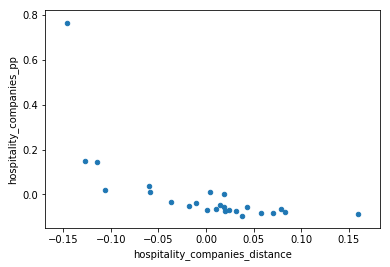

In [247]:
# safety 
safety_features = ['police_locations_pp', 'street_lights_pp','police_locations_distance']
zurich_indicators_df = create_indicator(safety_features,'safety_indic')

# hospitality 
hospitality_features = ['hospitality_companies_distance','hospitality_companies_pp']
zurich_indicators_df = create_indicator(hospitality_features,'hospitality_indic',zurich_indicators_df)

# handicapped access
hc_features = ['handicapp_pp','handicapp_distance']
zurich_indicators_df = create_indicator(hc_features,'handicapp_indic',zurich_indicators_df)
zurich_indicators_df.handicapp_indic = -zurich_indicators_df.handicapp_indic

# parks 
parks_features = ['parks_distance','parks_pp']
zurich_indicators_df = zurich_indicators_df = create_indicator(parks_features,'parks_indic',zurich_indicators_df)

# public facilities (pf)
pf_features = ['transport_rental_pp', 'fountains_pp','toilets_pp','street_art_pp']
zurich_indicators_df = create_indicator(pf_features,'pf_indic',zurich_indicators_df)

# community care  (cc)
cc_features = ['elderly_facilities_pp','community_facilities_pp']
zurich_indicators_df = create_indicator(cc_features,'cc_indic',zurich_indicators_df)

# sporting facilities (sf)
zurich_indicators_df = zurich_indicators_df.assign(sf_indic= scaled_zurich_metrics_df.sport_facilities_pp)

# child facilities (cf)
zurich_indicators_df = zurich_indicators_df.assign(cf_indic= scaled_zurich_metrics_df.child_facilities_pp)

scaled_zurich_metrics_df[hospitality_features].plot.scatter(x=hospitality_features[0], y=hospitality_features[1])
display(zurich_indicators_df)
zurich_indicators_df.to_csv(DATA_FOLDER + "zurich_indicators.csv")

## Plotting some of the Zurich indicators

In [229]:
#read zips data
zips = gpd.read_file(SHAPE_FOLDER + "zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

In [230]:
# extract only geometries and zips and join on zurich zips 
zurich_indicators_df = pd.merge(zurich_indicators_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
zurich_indicators_df = zurich_indicators_df.drop_duplicates('safety_indic')

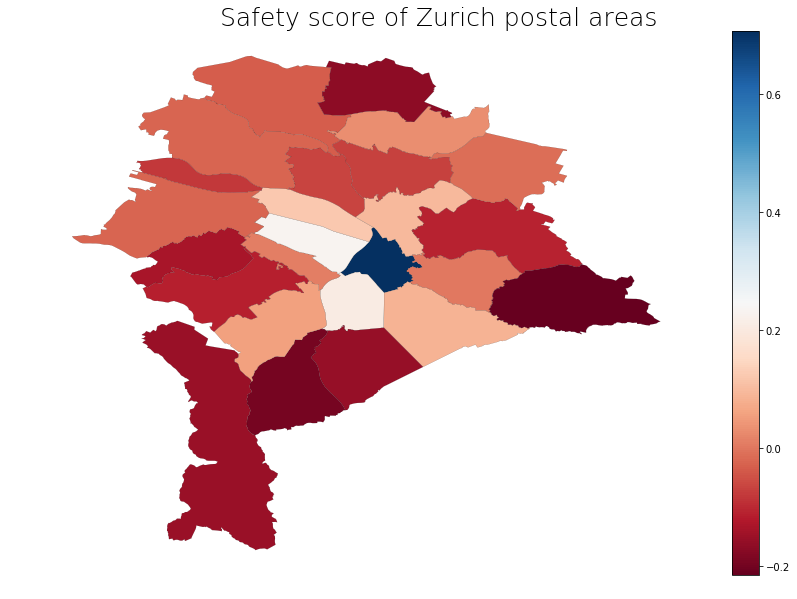

In [234]:
def plot_geopandas(gp, col_to_plot,title,colormap):
    '''
    This function creates a choropleth map using geopandas
    
    Parameters:
    gp = geodataframe data containing geometry column
    col_to_plot = column of data that must be plotted
    title = title of the map
    colormap = plt colormap to use, e.g. 'Blues', 'Accent', ...
    '''
    f, ax = plt.subplots(figsize=(15, 10))
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    
    # plotting settings
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    ax.set_aspect('equal')
    cax.set_aspect('equal')
    cax.set_axis_off()
    ax.set_axis_off()

    # get preferred colormap
    cmap = plt.cm.get_cmap(colormap)
    
    # plot data
    gp.plot(column=col_to_plot, ax=cax, linewidth=0.1, edgecolor='black',cmap=cmap)
    
    # create colorbar
    norm=plt.Normalize(vmin=gp[col_to_plot].min(), vmax=gp[col_to_plot].max())
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm._A = []
    f.colorbar(sm)
    
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(zurich_indicators_df), 'safety_indic', 'Safety score of Zurich postal areas','RdBu')

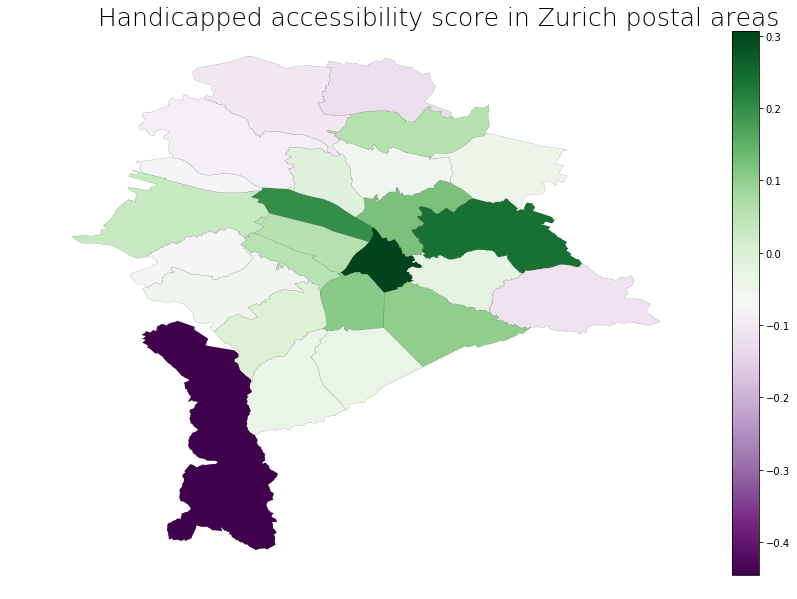

In [236]:
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(zurich_indicators_df), 'handicapp_indic',\
               'Handicapped accessibility score in Zurich postal areas','PRGn')

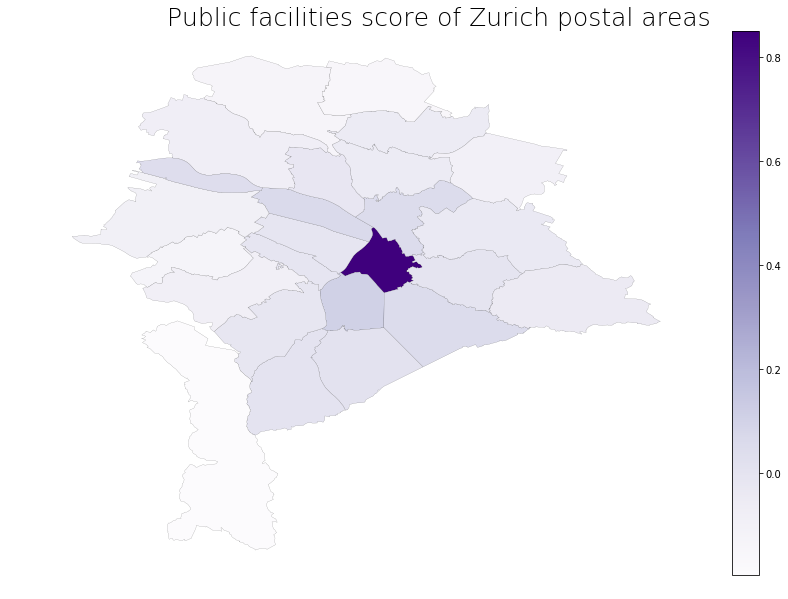

In [237]:
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(zurich_indicators_df), 'pf_indic',\
               'Public facilities score of Zurich postal areas','Purples')